In [0]:
import torch 
import torch.nn as nn
import torchvision.datasets as dsets
from skimage import transform
import torchvision.transforms as transforms
from torch.autograd import Variable
import pandas as pd;
import numpy as np;
from torch.utils.data import Dataset, DataLoader
#from vis_utils import *
import random;
import math;

In [0]:
num_epochs = 5;
batch_size = 100;
learning_rate = 0.001;

In [0]:
class FashionMNISTDataset(Dataset):
    '''Fashion MNIST Dataset'''
    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file
            transform (callable): Optional transform to apply to sample
        """
        
        data = pd.read_csv(csv_file);
        self.X = np.array(data.iloc[:, 1:]).reshape(-1, 1, 28, 28)#.astype(float);
        self.Y = np.array(data.iloc[:, 0]);
        
        del data;
        self.transform = transform;
        
    def __len__(self):
        return len(self.X);
    
    def __getitem__(self, idx):
        item = self.X[idx];
        label = self.Y[idx];
        
        if self.transform:
            item = self.transform(item);
        
        return (item, label);

In [0]:
train_dataset = FashionMNISTDataset(csv_file='/content/drive/My Drive/Colab Notebooks/data/fashionmnist/fashion-mnist_train.csv');
test_dataset = FashionMNISTDataset(csv_file='/content/drive/My Drive/Colab Notebooks/data/fashionmnist/fashion-mnist_test.csv')

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True);test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True);

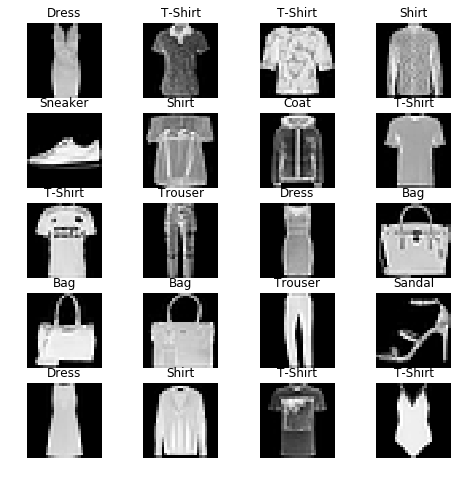

In [13]:
import matplotlib.pyplot as plt
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'};fig = plt.figure(figsize=(8,8));
columns = 4;
rows = 5;
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_dataset));
    img = train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

In [0]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(7*7*32, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [0]:
#instance of the Conv Net
cnn = CNN();#loss function and optimizer
criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate);

In [16]:
losses = [];
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):        
        images = Variable(images.float())
        labels = Variable(labels)
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        losses.append(loss)
        
        if (i+1) % 100 == 0:
            print ('Epoch : %d/%d, Iter : %d/%d,  Loss: %.4f' 
                   %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss)) 

Epoch : 1/5, Iter : 100/600,  Loss: 0.4110
Epoch : 1/5, Iter : 200/600,  Loss: 0.4500
Epoch : 1/5, Iter : 300/600,  Loss: 0.2689
Epoch : 1/5, Iter : 400/600,  Loss: 0.4010
Epoch : 1/5, Iter : 500/600,  Loss: 0.3216
Epoch : 1/5, Iter : 600/600,  Loss: 0.3750
Epoch : 2/5, Iter : 100/600,  Loss: 0.3736
Epoch : 2/5, Iter : 200/600,  Loss: 0.2943
Epoch : 2/5, Iter : 300/600,  Loss: 0.2755
Epoch : 2/5, Iter : 400/600,  Loss: 0.4267
Epoch : 2/5, Iter : 500/600,  Loss: 0.3126
Epoch : 2/5, Iter : 600/600,  Loss: 0.2605
Epoch : 3/5, Iter : 100/600,  Loss: 0.3222
Epoch : 3/5, Iter : 200/600,  Loss: 0.1602
Epoch : 3/5, Iter : 300/600,  Loss: 0.3514
Epoch : 3/5, Iter : 400/600,  Loss: 0.1896
Epoch : 3/5, Iter : 500/600,  Loss: 0.1999
Epoch : 3/5, Iter : 600/600,  Loss: 0.3319
Epoch : 4/5, Iter : 100/600,  Loss: 0.1357
Epoch : 4/5, Iter : 200/600,  Loss: 0.2125
Epoch : 4/5, Iter : 300/600,  Loss: 0.2434
Epoch : 4/5, Iter : 400/600,  Loss: 0.1610
Epoch : 4/5, Iter : 500/600,  Loss: 0.1758
Epoch : 4/5

In [18]:
cnn.eval()
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images.float())
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
    print('Test Accuracy of the model on the 10000 test images: %.4f %%' % (100 * correct / total))

Test Accuracy of the model on the 10000 test images: 93.0000 %
Test Accuracy of the model on the 10000 test images: 92.0000 %
Test Accuracy of the model on the 10000 test images: 92.0000 %
Test Accuracy of the model on the 10000 test images: 91.0000 %
Test Accuracy of the model on the 10000 test images: 90.0000 %
Test Accuracy of the model on the 10000 test images: 90.0000 %
Test Accuracy of the model on the 10000 test images: 91.0000 %
Test Accuracy of the model on the 10000 test images: 91.0000 %
Test Accuracy of the model on the 10000 test images: 91.0000 %
Test Accuracy of the model on the 10000 test images: 91.0000 %
Test Accuracy of the model on the 10000 test images: 91.0000 %
Test Accuracy of the model on the 10000 test images: 91.0000 %
Test Accuracy of the model on the 10000 test images: 90.0000 %
Test Accuracy of the model on the 10000 test images: 90.0000 %
Test Accuracy of the model on the 10000 test images: 90.0000 %
Test Accuracy of the model on the 10000 test images: 90

RoughWork Code Dumps

In [0]:
dat = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/fashionmnist/fashion-mnist_train.csv')

In [26]:
dat

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,...,211,220,214,74,0,255,222,128,0,0,0,0,0,0,0,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,0,114,183,112,55,23,72,102,165,160,28,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,24,188,163,93,...,171,249,207,197,202,45,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22,21,25,69,52,45,74,39,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,0,0,0,46,0,21,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,187,189,...,230,237,229,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,116,112,136,147,144,121,102,63,0,0,0,0,0,0,0,0,0,0
5,4,0,0,0,5,4,5,5,3,5,6,2,0,0,0,0,0,0,0,2,3,7,4,4,5,5,0,0,0,0,0,0,4,5,4,5,11,2,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,2,4,9,7,8,7,5,4,8,12,5,7,8,7,4,3,7,5,0,0,0
6,4,0,0,0,0,0,0,0,0,0,0,0,0,159,161,143,180,142,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,...,255,231,241,217,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,36,50,51,68,48,48,33,14,0,0,0,0,0,0,0,0,0
7,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,4,0,0,0,0,0,0,3,2,0,0,60,234,215,229,223,231,107,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,224,...,0,0,0,2,0,77,210,204,156,0,0,0,0,0,0,1,76,88,35,0,0,2,5,7,3,3,3,3,7,5,1,0,0,0,0,0,0,0,0,0
9,8,0,0,0,0,0,0,0,0,0,0,0,1,0,0,141,45,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,238,229,227,223,255,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,220,215,210,198,185,188,194,177,189,198,203,214,166,0,0,0,0,0,0,0


In [0]:
datnp = np.array(dat.iloc[:, 1:]).reshape(-1, 3, 28, 28)#.astype(float);
datnp0 = np.array(dat.iloc[:, 0]);

In [42]:
datnp.shape

(20000, 3, 28, 28)

In [43]:
datnp

array([[[[  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0],
         ...,
         [  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0]],

        [[  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0],
         ...,
         [  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0]],

        [[  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0],
         ...,
         [  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0]]],


       [[[  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ..., 

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


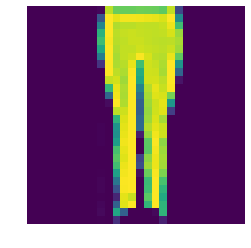

In [51]:
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(datnp));
    img = datnp[img_xy][0]
    fig.add_subplot(rows, columns, i)
    #plt.title(labels_map[datnp[img_xy][1]])
    plt.axis('off')
    plt.imshow(img)
plt.show()